#### Ejecicio #1:    Dado un dataset X, calcular PCA para reducir dimensión.
Siguiendo los pasos vistos en la teoría y utilizando el [notebook](PCA%20en%20NumPy.ipynb) de referencia, se requiere utilizar numpy para calcular PCA del dataset de entrada X, utilizando la componente más importantes.

X = np.array( [ [0.8, 0.7] , [0.1, -0.1] ] )

Al finalizar la implementación en numpy, corroborar obtener los mismos resultados que utilizando el código de la librería scikit-learn. Escribir un test para comparar las matrices.

_Todas las operaciones debe ser vectorizadas._


In [1]:
import numpy as np

def pca(data, n):
    """
    This function implements PCA using only mumpy
    
    :param data: the data from which the principal components have to be extracted.
    :param n: The number of components to obtain from the data.
    :return: np.array with the data expressed using the principal components
    """
    
    # Normalize the data
    data_n = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # Get the covariance matrix
    cov_matrix = np.cov(data_n, rowvar=False)

    # Obtain eigenvalues and eigenvectors from the covariance matrix
    eig_values, eig_vectors = np.linalg.eig(cov_matrix)

    # Sort the eigenvectors matrix using their eigen values in decreasing order
    indices = eig_values.argsort()[::-1]
    eig_vectors = eig_vectors[:, indices[:n]]
    
    # Return the principal components and the data expressed with them
    return data_n.dot(eig_vectors)


In [2]:
# Compare the previous implementation with the one available in sklearn

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define an array for the test
data = np.array([[0.8, 0.7], [0.1, -0.1]])

# Get the data expressed in their principal component using my implementation
print('Using my implementation:', pca(data, 1))

# Use now sklearn's implementation
pca_obj = PCA(n_components=1)
print(
    'Using sk-learn`s implementation:',
    pca_obj.fit_transform(StandardScaler().fit_transform(data)),
)


Using my implementation: [[ 1.41421356]
 [-1.41421356]]
Using sk-learn`s implementation: [[-1.41421356]
 [ 1.41421356]]


#### Observation:

Por alguna razón que no logro descubrir me están dando al revés los resultados.

Tratando de encontrar la diferencia, comparé con la solución propuesta:

```Python
def pca_numpy(X, n_components=2):
    """
    :param X: numpy array con los datos a reducir
    :param n_components: n° de componentes principales a utilizar
    :return: autovalores, PCA sobre X para el n° de componentes
    """
    X = X - X.mean(axis=0)
    cov = np.cov(X.T)/X.shape[0]
    # v son los autovalores y w los autovectores
    v, w = np.linalg.eig(cov)
    idx = v.argsort()[::-1]
    v = v[idx]
    w = w[:, idx]
    return v[:n_components], X.dot(w[:, :n_components])

```

En relación a esto noté 3 cosas que me llamaron la atención:

1. por qué no se normaliza dividiendo por la desviación estándar?
2. por qué se divide a la matriz de covarianza por la cantidad de muestras?
3. en mi caso los índices son [0 1] mientras que en la propuesta son [1 0], y no logro ver por qué se da esa diferencia

#### Ejercicio #2: 
Siguiendo los ejemplos vistos en clase sobre los datasets de Human Activity Recognition y Fashion MNIST, realizar las siguientes consignas en el 
[notebook](PCA%20-%20MNIST.ipynb):

1. Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?
2. Graficar un scree plot (varianza contemplada en función del número de componentes considerados)
3. Visualizar gráficamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente? [OPCIONAL].
4. Visualizar la imagen original vs. la reconstruida con los  𝑚  componentes del punto 1.
5. Graficar una matriz de correlación del dataset reducido.
6. Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.
7. Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?
8. Realizar un gráfico de inercia para obtener el número óptimo de clusters  𝑘 .
9. Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito dándole valores a los primeros dos componentes de PCA.

# PCA - Fashion MNIST

En éste ejercicio vamos a aplicar PCA y K-means al digits dataset similar a MNIST, que incluye imágenes de dígitos de 8x8 píxeles. La idea es intentar recopilar información sobre la distribución de las imágenes, usando visualizaciones que permitan clarificar cómo interpretar los resultados obtenidos por PCA.

### Importamos librerías

In [3]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os
import gzip
import sys
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize 
from sklearn.datasets import load_digits

In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Importamos el dataset

In [5]:
# Cargamos los datos de training
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


In [6]:
print('Formato de las etiquetas: {}'.format(y.shape))

Formato de las etiquetas: (1797,)


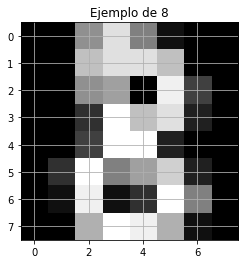

In [7]:
# Cargamos una muestra
plt.grid(True)
plt.title("Ejemplo de {}".format(y[8]))
plt.imshow(X[8, :].reshape((8, 8)), cmap='gray')

In [8]:
# 1.- Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?

# alculate the number of elements that are needed for explaining 90% of the variance
pca_obj = PCA()
pca_obj.fit_transform(StandardScaler().fit_transform(X))
n_components = 0
cumulative_sum = 0
for i, element in enumerate(pca_obj.explained_variance_ratio_):
    cumulative_sum += element
    if cumulative_sum > 0.9:
        n_components = i + 1
        break

total_comps = len(pca_obj.explained_variance_ratio_)
print('The needed components are {} out of {} ({}%)'.format(
    n_components,
    total_comps,
    n_components * 100 / total_comps,
))

The needed components are 31 out of 64 (48.4375%)


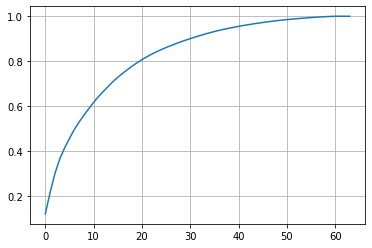

In [9]:
# 2.- Graficar un scree plot (varianza contemplada en función del número de componentes considerados)

# Calculate the accumulated variance
acc = np.empty(total_comps)
for i, elem in enumerate(pca_obj.explained_variance_ratio_):
    if i == 0:
        acc[i] = elem
        continue
    acc[i] = acc[i - 1] + elem

plt.plot(acc)
plt.grid()
plt.show()

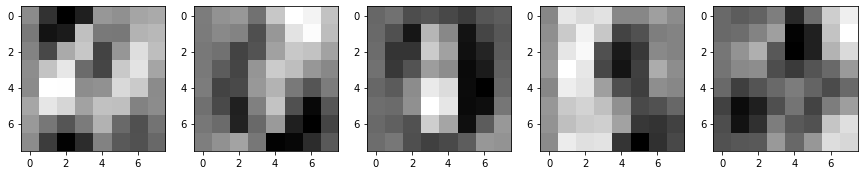

In [10]:
# 3.- Visualizar gráficamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente? [OPCIONAL].

# Plot the first 5 components
plt.figure(0, figsize=(15, 3))
for i in range(5):
    plt.subplot2grid((1, 5), (0, i))
    plt.imshow(np.array(pca_obj.components_[i]).reshape((8, 8)), cmap='gray')
plt.show()

#### Interpretación de los resultados:

1. Círculos
2. Diagonal desde abajo a la izquierda hacia arriba a la derecha, con más sensibilidad en la esquina superior derecha
3. Línea vertical centrada
4. Mitad izquierda
5. Margen derecho

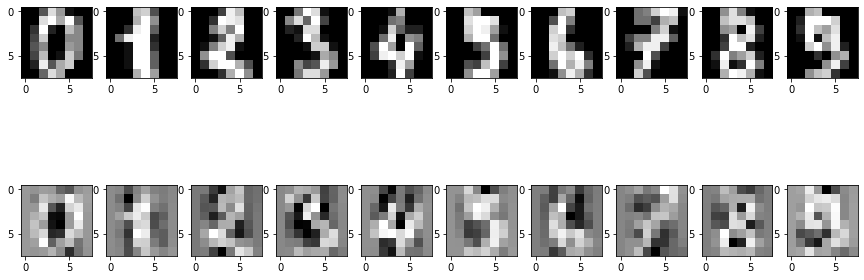

In [11]:
# 4.- Visualizar la imagen original vs. la reconstruida con los 𝑚 componentes del punto 1.

# Reduce dimensionality
pca_31 = PCA(n_components=n_components)
output = pca_31.fit_transform(X)

# Load all components in a numpy array
components = np.array(pca_31.components_)
components = components[:n_components]

# Plot the original and the reconstructed for the 10 digits
plt.figure(0, figsize=(15, 6))
for i in range(10):
    # Plot the original
    ax = plt.subplot2grid((2, 10), (0, i))
    ax.imshow(X[i, :].reshape((8, 8)), cmap='gray')

    # Plot the reconstructed
    ax = plt.subplot2grid((2, 10), (1, i))
    reconstruction = np.dot(components.T, np.array(output[i]))
    ax.imshow(reconstruction.reshape((8, 8)), cmap='gray')
plt.show()

In [12]:
# 5.- Graficar una matriz de correlación del dataset reducido.

# Import Pandas
import pandas as pd

# Calculate correlation matrix using pandas and show it
df = pd.DataFrame(components.T)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,1,-0.000204146,-7.34861e-05,0.000271235,0.000419329,0.00181487,0.00123264,0.00127551,0.000834956,0.00434806,0.000507879,-0.00132646,0.00180752,-0.00381862,0.00217072,0.000799725,-0.00217421,0.001917,0.0011818,0.00232192,0.00224302,-0.000950404,-0.00123435,-6.80117e-05,-0.000539043,0.000152283,-0.000798568,0.000441694,-0.00058464,-0.000103453,-0.000133499
1,-0.000204146,1,-0.000158955,0.000586698,0.000907035,0.00392568,0.00266628,0.00275901,0.00180606,0.00940512,0.00109857,-0.00286922,0.00390978,-0.00825991,0.0046954,0.00172985,-0.00470295,0.00414659,0.00255631,0.00502246,0.00485179,-0.00205578,-0.00266998,-0.000147114,-0.00116598,0.000329397,-0.00172735,0.000955411,-0.00126461,-0.000223776,-0.000288766
2,-7.34861e-05,-0.000158955,1,0.000211193,0.000326504,0.00141312,0.000959776,0.000993158,0.000650126,0.00338555,0.000395452,-0.00103283,0.0014074,-0.00297331,0.0016902,0.000622693,-0.00169291,0.00149264,0.000920192,0.00180793,0.00174649,-0.000740017,-0.000961108,-5.29563e-05,-0.000419717,0.000118572,-0.000621792,0.000343918,-0.000455221,-8.05523e-05,-0.000103947
3,0.000271235,0.000586698,0.000211193,1,-0.00120512,-0.0052158,-0.00354251,-0.00366572,-0.00239959,-0.012496,-0.0014596,0.00381215,-0.00519467,0.0109744,-0.00623847,-0.00229834,0.0062485,-0.0055093,-0.0033964,-0.00667301,-0.00644625,0.00273138,0.00354742,0.00019546,0.00154916,-0.000437647,0.00229502,-0.00126939,0.00168021,0.000297316,0.000383665
4,0.000419329,0.000907035,0.000326504,-0.00120512,1,-0.00806362,-0.00547671,-0.0056672,-0.00370977,-0.0193188,-0.00225654,0.00589358,-0.00803096,0.0169664,-0.00964468,-0.00355324,0.00966018,-0.00851738,-0.00525084,-0.0103165,-0.0099659,0.00422272,0.00548431,0.000302181,0.00239501,-0.000676603,0.0035481,-0.00196248,0.0025976,0.000459651,0.000593146
5,0.00181487,0.00392568,0.00141312,-0.0052158,-0.00806362,1,-0.0237034,-0.0245279,-0.016056,-0.0836124,-0.00976642,0.0255076,-0.0347583,0.0734313,-0.0417425,-0.0153786,0.0418096,-0.0368636,-0.0227258,-0.0446501,-0.0431328,0.0182761,0.0237363,0.00130785,0.0103657,-0.00292836,0.0153563,-0.00849369,0.0112425,0.00198939,0.00256716
6,0.00123264,0.00266628,0.000959776,-0.00354251,-0.00547671,-0.0237034,1,-0.016659,-0.0109051,-0.0567885,-0.00663323,0.0173245,-0.0236074,0.0498737,-0.028351,-0.0104449,0.0283966,-0.0250373,-0.0154351,-0.0303258,-0.0292953,0.0124129,0.0161214,0.000888277,0.00704025,-0.00198891,0.0104298,-0.00576881,0.00763578,0.00135117,0.00174358
7,0.00127551,0.00275901,0.000993158,-0.00366572,-0.0056672,-0.0245279,-0.016659,1,-0.0112844,-0.0587637,-0.00686394,0.0179271,-0.0244285,0.0516083,-0.0293371,-0.0108082,0.0293843,-0.0259081,-0.015972,-0.0313806,-0.0303142,0.0128446,0.0166821,0.000919172,0.00728511,-0.00205809,0.0107926,-0.00596946,0.00790136,0.00139816,0.00180423
8,0.000834956,0.00180606,0.000650126,-0.00239959,-0.00370977,-0.016056,-0.0109051,-0.0112844,1,-0.0384669,-0.00449316,0.0117351,-0.015991,0.033783,-0.0192042,-0.0070751,0.0192351,-0.0169596,-0.0104553,-0.0205419,-0.0198438,0.00840815,0.0109202,0.000601694,0.00476887,-0.00134723,0.00706486,-0.00390763,0.00517226,0.000915243,0.00118105
9,0.00434806,0.00940512,0.00338555,-0.012496,-0.0193188,-0.0836124,-0.0567885,-0.0587637,-0.0384669,1,-0.0233983,0.061111,-0.0832737,0.175926,-0.100006,-0.0368438,0.100167,-0.0883174,-0.0544464,-0.106972,-0.103337,0.0437857,0.0568673,0.00313334,0.024834,-0.00701575,0.0367905,-0.0203491,0.0269347,0.00476616,0.00615038


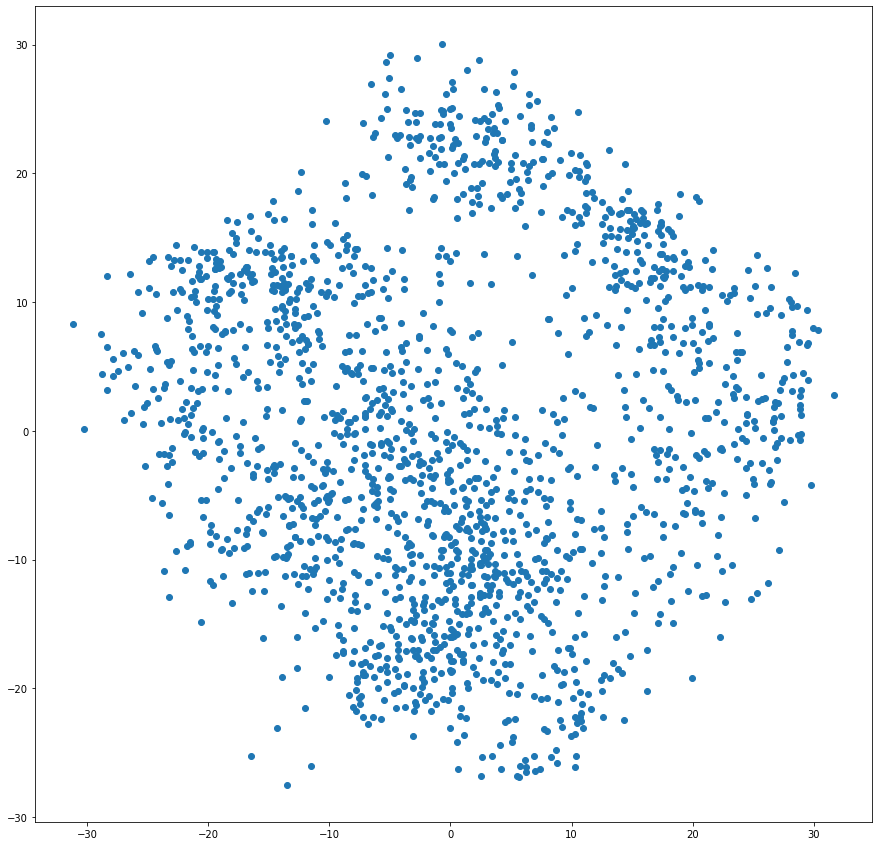

In [13]:
# 6.- Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.

# Reduce dimensionality to 2 components
n_components = 2
pca_2 = PCA(n_components=n_components)
output = pca_2.fit_transform(X)

# Plot the original and the reconstructed for the 10 digits
plt.figure(0, figsize=(15, 15))
plt.scatter(output[:, 0], output[:, 1])
plt.show()

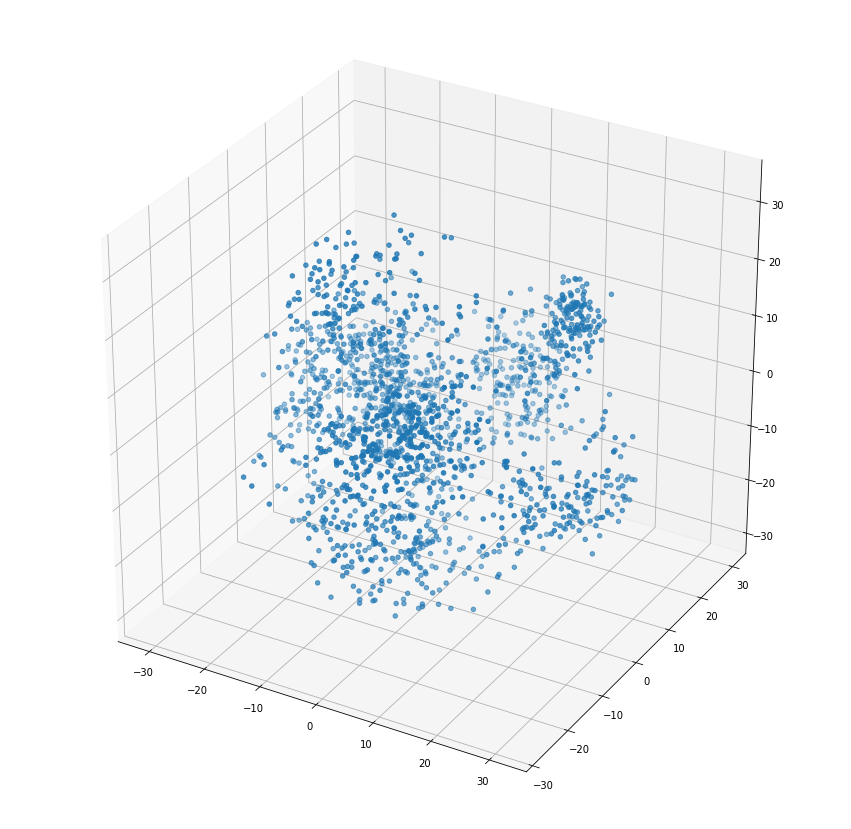

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce dimensionality to 3 components
n_components = 3
pca_3 = PCA(n_components=n_components)
output = pca_3.fit_transform(X)

# Plot the original and the reconstructed for the 10 digits
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.scatter(output[:, 0], output[:, 1], output[:, 2])


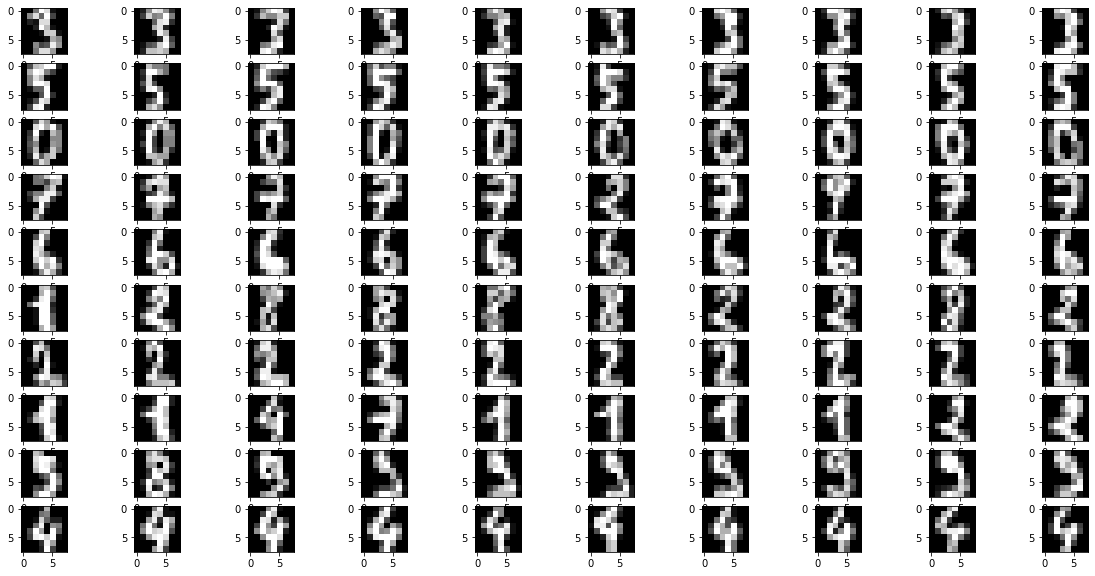

In [15]:
# 7.- Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?

from sklearn.cluster import KMeans

# Clusterize
kmeans = KMeans(n_clusters=10).fit(X)

# Make one row for each label
plt.figure(0, figsize=(20, 10))
for j in range(10):
    # Plot up to 10 digits of the same cluster
    horizontal = 0
    for i, l in enumerate(kmeans.labels_):
        if l != j:
            # Avoid printing images which aren't in the current cluster
            continue
        ax = plt.subplot2grid((10, 10), (j, horizontal))
        ax.imshow(X[i, :].reshape((8, 8)), cmap='gray')
        horizontal += 1
        if horizontal == 10:
            # Avoid exceeding the total width
            break

# kmeans.cluster_centers_

A partir de lo que se muestra arriba, se puede ver que,
a pesar de que en muchos casos el clusterizado funciona muy bien (para el 0, 2, 3, 5, 6 y 7),
para otros no tanto (1, 4 8 y 9).

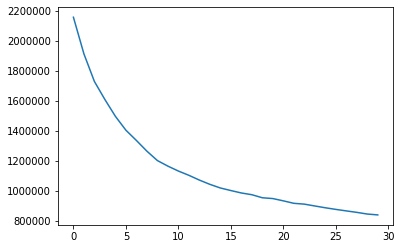

In [16]:
# 8.- Realizar un gráfico de inercia para obtener el número óptimo de clusters 𝑘 .

# Calculate inertia for 1 to 30 clusters
inertias = np.empty(30)
for n_clusters in range(1, 31):
    # Clusterize
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    inertias[n_clusters - 1] = kmeans.inertia_

plt.figure()
plt.plot(inertias)

A partir de la imagen anterior, parecería sensato tomar un número entre 10 y 15,
pero al saber que los dígitos son 10, lo más sensato sería tomar k = 10

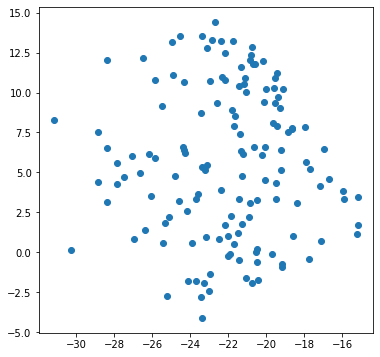

In [22]:
# 9.- Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito
#     dándole valores a los primeros dos componentes de PCA.

# Reduce dimensionality to 2 components
n_components = 2
pca_2 = PCA(n_components=n_components)
output = pca_2.fit_transform(X)

# Apply K-means to the onbtained components
kmeans = KMeans(n_clusters=10).fit(output)

# Gather all elements of the fifth cluster
fifth_cluster = np.empty((0, 2))
for label, comp in zip(kmeans.labels_, output):
    if label != 4:
        continue
    fifth_cluster = np.append(fifth_cluster, comp.reshape(1, 2), axis=0)

# Plot the coordinates of the points in the cluster
plt.figure(0, figsize=(6, 6))
plt.scatter(fifth_cluster[:, 0], fifth_cluster[:, 1])
plt.show()

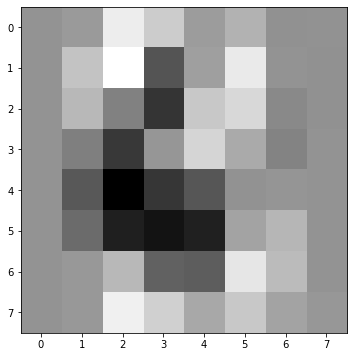

In [23]:
# Generate the image artificially

# Load all components in a numpy array
n_components = 2
components = np.array(pca_2.components_)
components = components[:n_components]

# Plot the original and the reconstructed for the 10 digits
plt.figure(0, figsize=(6, 6))

# Plot the reconstructed
reconstruction = np.dot(components.T, np.array([-24, 5]))
plt.imshow(reconstruction.reshape((8, 8)), cmap='gray')


Podría ser un número 3, aunque no estoy muy convencido